In [13]:
import torch
import torchaudio
import pandas
import os
import numpy
from torch import nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torch.utils.data as data
import librosa
device = "cuda:0"
if not torch.cuda.is_available():
    Exception("cuda not found")

# Dataset

In [14]:
annotations_path = r"datasets/spcup2022/labels.csv"
audio_dir = r"datasets/spcup2022"
df = pandas.read_csv(annotations_path)
df.groupby(['algorithm']).count()

,track
algorithm,
0,1000
1,1000
2,1000
3,1000
4,1000


In [15]:
annotations = pandas.read_csv(annotations_path)
audio_paths = [os.path.join(audio_dir, annotations.iloc[idx,0]) for idx in range(len(annotations.iloc[:,0])) ]
durations = [librosa.get_duration(filename=path) for path in audio_paths]
df = df.assign(duration=durations)

# Single Process 

In [16]:
# non_silent_durations = []
# from tqdm import tqdm
# progress = tqdm(audio_paths)
# for path in progress:
#     y, sr = librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=numpy.float32, res_type='kaiser_best')
#     y, idx = librosa.effects.trim(y=y, frame_length=sr, top_db=60)

#     S = librosa.stft(y)
#     librosa.get_duration(S=S, sr=sr)

#     non_silent_durations.append(librosa.get_duration(filename=path))
# df.assign(non_silent_duration=non_silent_durations)

# Multi Process

In [17]:
non_silent_durations = []
import torch.multiprocessing as mp

def get_non_silent_duration(path):
    y, sr = librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=numpy.float32, res_type='kaiser_best')
    y, idx = librosa.effects.trim(y=y, frame_length=sr, top_db=40)

    S = librosa.stft(y)
    librosa.get_duration(S=S, sr=sr)

    return librosa.get_duration(filename=path)
p = mp.Pool(32*4)

non_silent_durations = list(p.imap(get_non_silent_duration, audio_paths))
df = df.assign(non_silent_duration=non_silent_durations)

In [18]:
df.sum()

track                  00050dd7458cf08e594c797930696bce.wav00070e7c53...
algorithm                                                          10000
duration                                                    34794.398813
non_silent_duration                                         34794.398813
dtype: object

In [20]:
class SynthesizeAudioDataset(Dataset):
    def __init__(self, annotations_file,
                 audio_dir,
                 transform,
                 target_sample_rate,
                 num_samples,
                ):
        self.annotations = pandas.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        target = self.annotations.iloc[index,1]
        audio_path = os.path.join(self.audio_dir, self.annotations.iloc[index,0])
        signal, sr = torchaudio.load(audio_path)
        signal = signal
        signal = self._resample(signal, sr)
        signal = self._mix_channels(signal)
        signal = self._cut_signal(signal)
        signal = self._padding_signal(signal)
        signal = self.transform(signal)
        return signal, target
    
    def _mix_channels(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
        
    def _resample(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    def _cut_signal(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:,:self.num_samples]
        return signal
    
    def _padding_signal(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

In [21]:
SAMPLE_RATE = 22050
NUM_SAMPLE = 22050
batch_size = 64

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)
dataset = SynthesizeAudioDataset(annotations_path, audio_dir, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLE,)

train_loader = DataLoader(dataset, batch_size=batch_size)

(-0.5, 360.5, 520.5, -0.5)

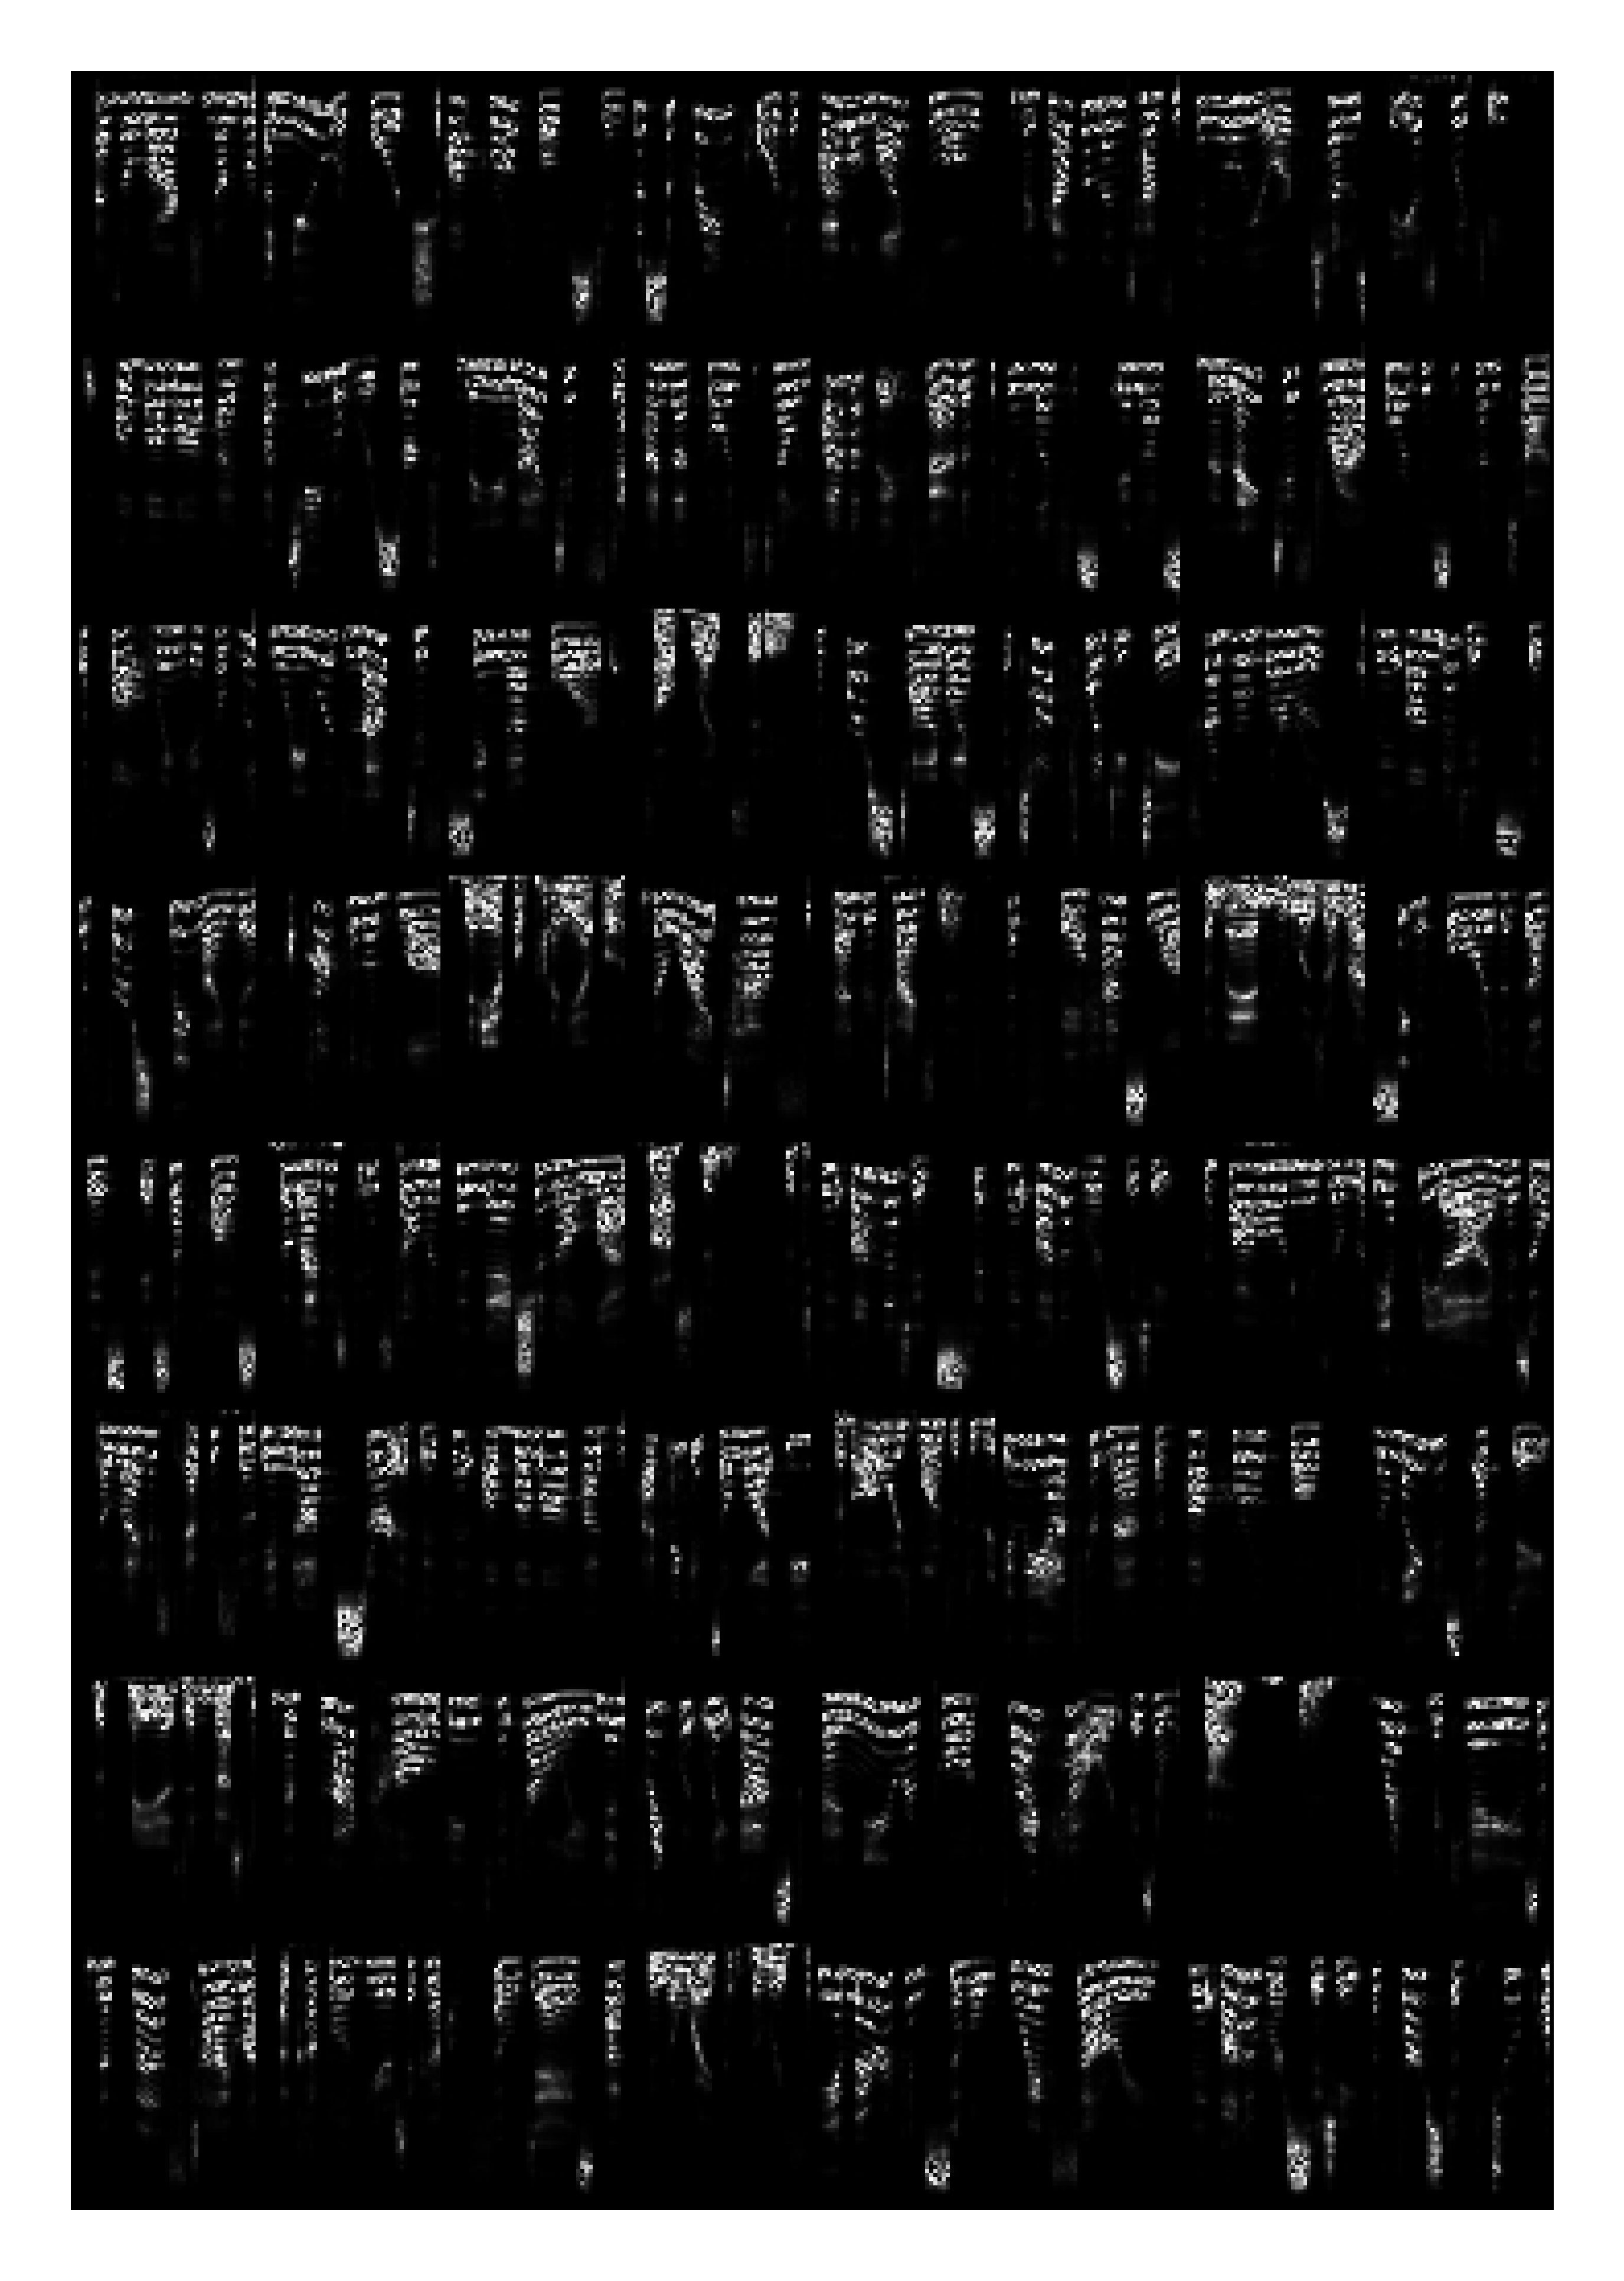

In [23]:
spectrograms, targets = next(iter(train_loader))
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(spectrograms, padding=1)

# torchvision.utils.save_image(grid,"batch.png")

plt.figure(dpi=1200)
plt.imshow(grid.type(torch.uint8).permute(1,2,0).detach().cpu())
plt.axis('off')